# Train on notebook

In [1]:
# Basic libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from typing import List

In [2]:
os.chdir("../")
# Personalized modules
from preprocess.dataloader import AntibodiesTree
from preprocess.patches_utils import PatchesUtilities

from osgen.embeddings import StyleExtractor
from osgen.utils import Utilities
from osgen.vae import VanillaVAE,VanillaEncoder, VanillaDecoder
from osgen.base import BaseModel
from osgen.nn import *
from osgen.unet import *
from osgen.loss import *

/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# Directory where your tumor PNGs are stored
directory = '/root/BiOSGen/data/NKX3'

for filename in os.listdir(directory):
    if filename.endswith('.png') and 'NKX3' not in filename and 'NKX' in filename:
        new_filename = filename.replace('NKX', 'NKX3')
        old_path = os.path.join(directory, filename)
        new_path = os.path.join(directory, new_filename)
        os.rename(old_path, new_path)
        print(f'Renamed: {filename} -> {new_filename}')


In [4]:
# SRC antibodies
tree_src = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/HE",
    mask_dir = "/root/BiOSGen/data/tissue_masks/HE",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/HE"
)

# DST antibodies
tree_dst = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/NKX3",
    mask_dir = "/root/BiOSGen/data/tissue_masks/NKX3",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/NKX3"
)

# Print
print("Nb antibodies: ", tree_src.get_nb_antibodies())
print("Nb antibodies: ", tree_dst.get_nb_antibodies())

Nb antibodies:  248
Nb antibodies:  248


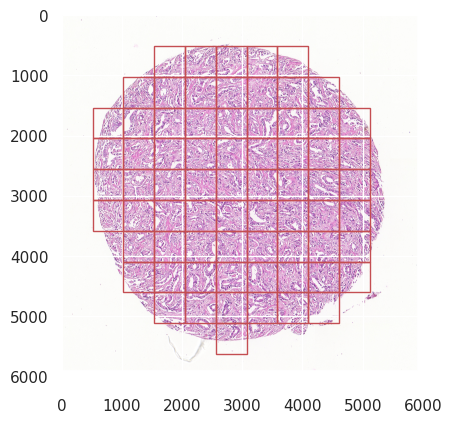

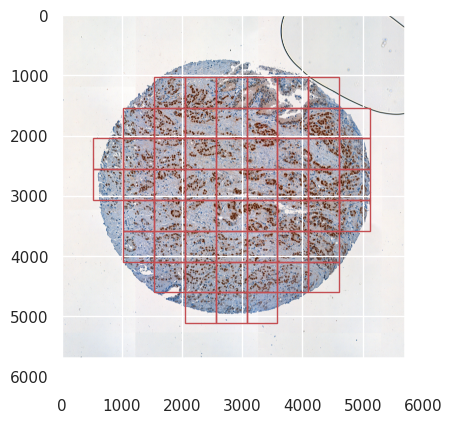

In [5]:
patches_src = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_src.antibodies[0])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[0]))),
)

patches_dst = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_dst.antibodies[0])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_dst.antibodies[0]))),
)

In [6]:
# Define hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Define VAE
# 3. Instantiate the model
vae = VanillaEncoder(
    in_channels=3,
    latent_dim=64,  # You can choose a different latent dimension
    hidden_dims=[32, 64]
).to(device)
Utilities.convert_model_to_bf16(vae)

VanillaEncoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=64, out_features=64, bias=True)
  (fc_var): Linear(in_features=64, out_features=64, bias=True)
  (noise_predictor): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_input): Linear(in_features=64, out_features=16384, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, mome

In [8]:
vae.count_dtypes()

torch.bfloat16: 22 parameters
torch.float32: 4 parameters


In [9]:
test_patch_src = patches_src[10]
test_patch_dst = patches_dst[10]


test_patch_src_tensor = Utilities.convert_numpy_to_tensor(test_patch_src)
test_patch_dst_tensor = Utilities.convert_numpy_to_tensor(test_patch_dst)

print("test_patch_src_tensor shape: ", test_patch_src_tensor.shape)
print("test_patch_dst_tensor shape: ", test_patch_dst_tensor.shape)

test_patch_src_tensor shape:  torch.Size([1, 3, 512, 512])
test_patch_dst_tensor shape:  torch.Size([1, 3, 512, 512])


In [10]:
test_patch_src_tensor = test_patch_src_tensor.to(device, dtype=torch.bfloat16)
with torch.no_grad():
    with torch.amp.autocast(device_type='cuda',dtype=torch.bfloat16):
        en = vae(test_patch_src_tensor)
en.shape

torch.Size([1, 64, 128, 128])

In [11]:
# Define UNET
# Create model with matching in_channels
model = AdaINUNet(
    in_channels=64,  # Changed from 3 to 64 to match your input
    out_channels=3,
    time_emb_dim=128,
    base_channels=64,
    channel_mults=(1, 2, 4, 8),  # Creates a model with 4 resolution levels
    num_res_blocks=2,            # 2 residual blocks per resolution
    attention_resolutions=(4, 8),  # Add attention at 8×8 and 16×16 resolutions
    dropout=0.1,
    style_strength=1.0,
    device=device
).to(device)

# Convert model parameters to bfloat16
for param in model.parameters():
    param.data = Utilities.convert_to_bfloat16(param.data)

In [12]:
model.count_dtypes()

torch.bfloat16: 298 parameters


In [13]:
# Define StyleExtractor
extractor = StyleExtractor()
extractor = extractor.to(device='cuda', dtype=torch.bfloat16)

with torch.no_grad():
    with torch.amp.autocast(device_type='cuda',dtype=torch.bfloat16):
        encoded = extractor(test_patch_src_tensor)

encoded.view(1, 64, 128, 128).shape

/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 64, 128, 128])

In [14]:
# Define Decoder
decoder = VanillaDecoder(in_channels=64, latent_dim=64, output_channels=3).to('cuda', dtype=torch.bfloat16)  # [1, 64, 64, 64]

In [15]:
pipeline = nn.Sequential(
    vae,
    model,
    decoder
).to(device='cuda', dtype=torch.bfloat16)

In [16]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")


Number of trainable parameters: 61412480


In [17]:
import torch.optim as optim


In [20]:
# Hyperparameters for training
num_epochs = 10
batch_size = 1

learning_rate = 1e-4
losses = []
optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], 
                lr=1e-3,  # Start with a lower learning rate 
                weight_decay=1e-8)  # Add weight decay to prevent overfitting

lambda_structure = 1e-5
lambda_content=1e-3
lambda_style=1e-3
lambda_color=1e-4 
# Put on training mode
model.train
vae.train()
decoder.train()
extractor.train()


for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for i, (src, dst) in enumerate(zip(patches_src, patches_dst)):
        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst)

        # Move to device
        src_tensor = src_tensor.to(device, dtype=torch.bfloat16)
        dst_tensor = dst_tensor.to(device, dtype=torch.bfloat16)

        # Timesteps
        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # Forward pass
        with torch.amp.autocast(device_type='cuda',dtype=torch.bfloat16):
            encoded = vae(src_tensor)
            style = extractor(dst_tensor)
            style = style.view(batch_size, 64, 128, 128)
            output = model(encoded, timesteps, style)  # Use random timesteps

            # Decode the output
            reconstructed = decoder(output)


        # Compute loss
        structure_l = structure_preservation_loss(
            original_image=src_tensor, 
            generated_image=reconstructed,
            lambda_structure=lambda_structure,
        )
        ca_l = color_alignment_loss(
            original_image=src_tensor,
            generated_image=reconstructed,
            lambda_color=lambda_color
        )
        content_l = content_loss(
            original_image=src_tensor,
            generated_image=reconstructed,
            lambda_content=lambda_content
        )
        style_l = style_loss(
            original_image=src_tensor,
            generated_image=reconstructed,
            lambda_style=lambda_style
        )

        loss = total_loss(
            original_image=src_tensor, 
            generated_image=reconstructed,
            lambda_structure=lambda_structure,
            lambda_content=lambda_content,
            lambda_style=lambda_style,
            lambda_color=lambda_color
        )


        # Backward pass and optimization
        optimizer.zero_grad()
        structure_l.backward()
        ca_l.backward()
        content_l.backward()
        style_l.backward()
        optimizer.step()

        # losses.append(loss.item())

    print(f"Loss: {loss.item()}, Structure Loss: {structure_l.item()}, Color Loss: {ca_l.item()}, Content Loss: {content_l.item()}, Style Loss: {style_l.item()}")

Epoch 1/10


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

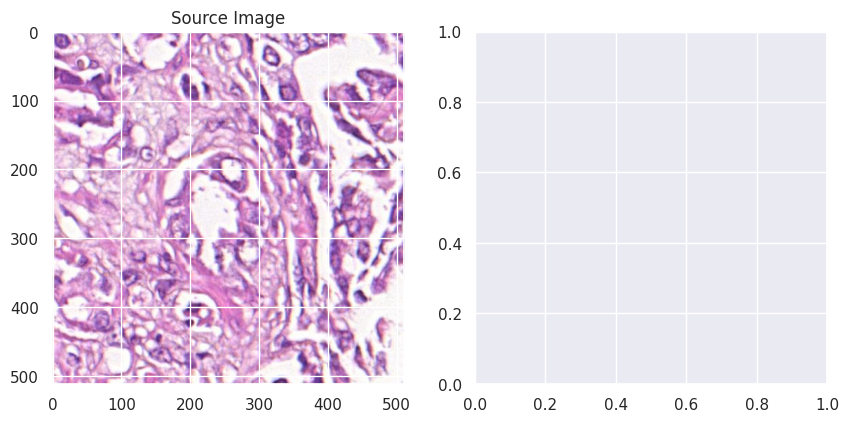

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(src)
ax[0].set_title("Source Image")

ax[1].imshow(reconstructed)
ax[1].set_title("Reconstructed Image")

plt.tight_layout()
plt.show()


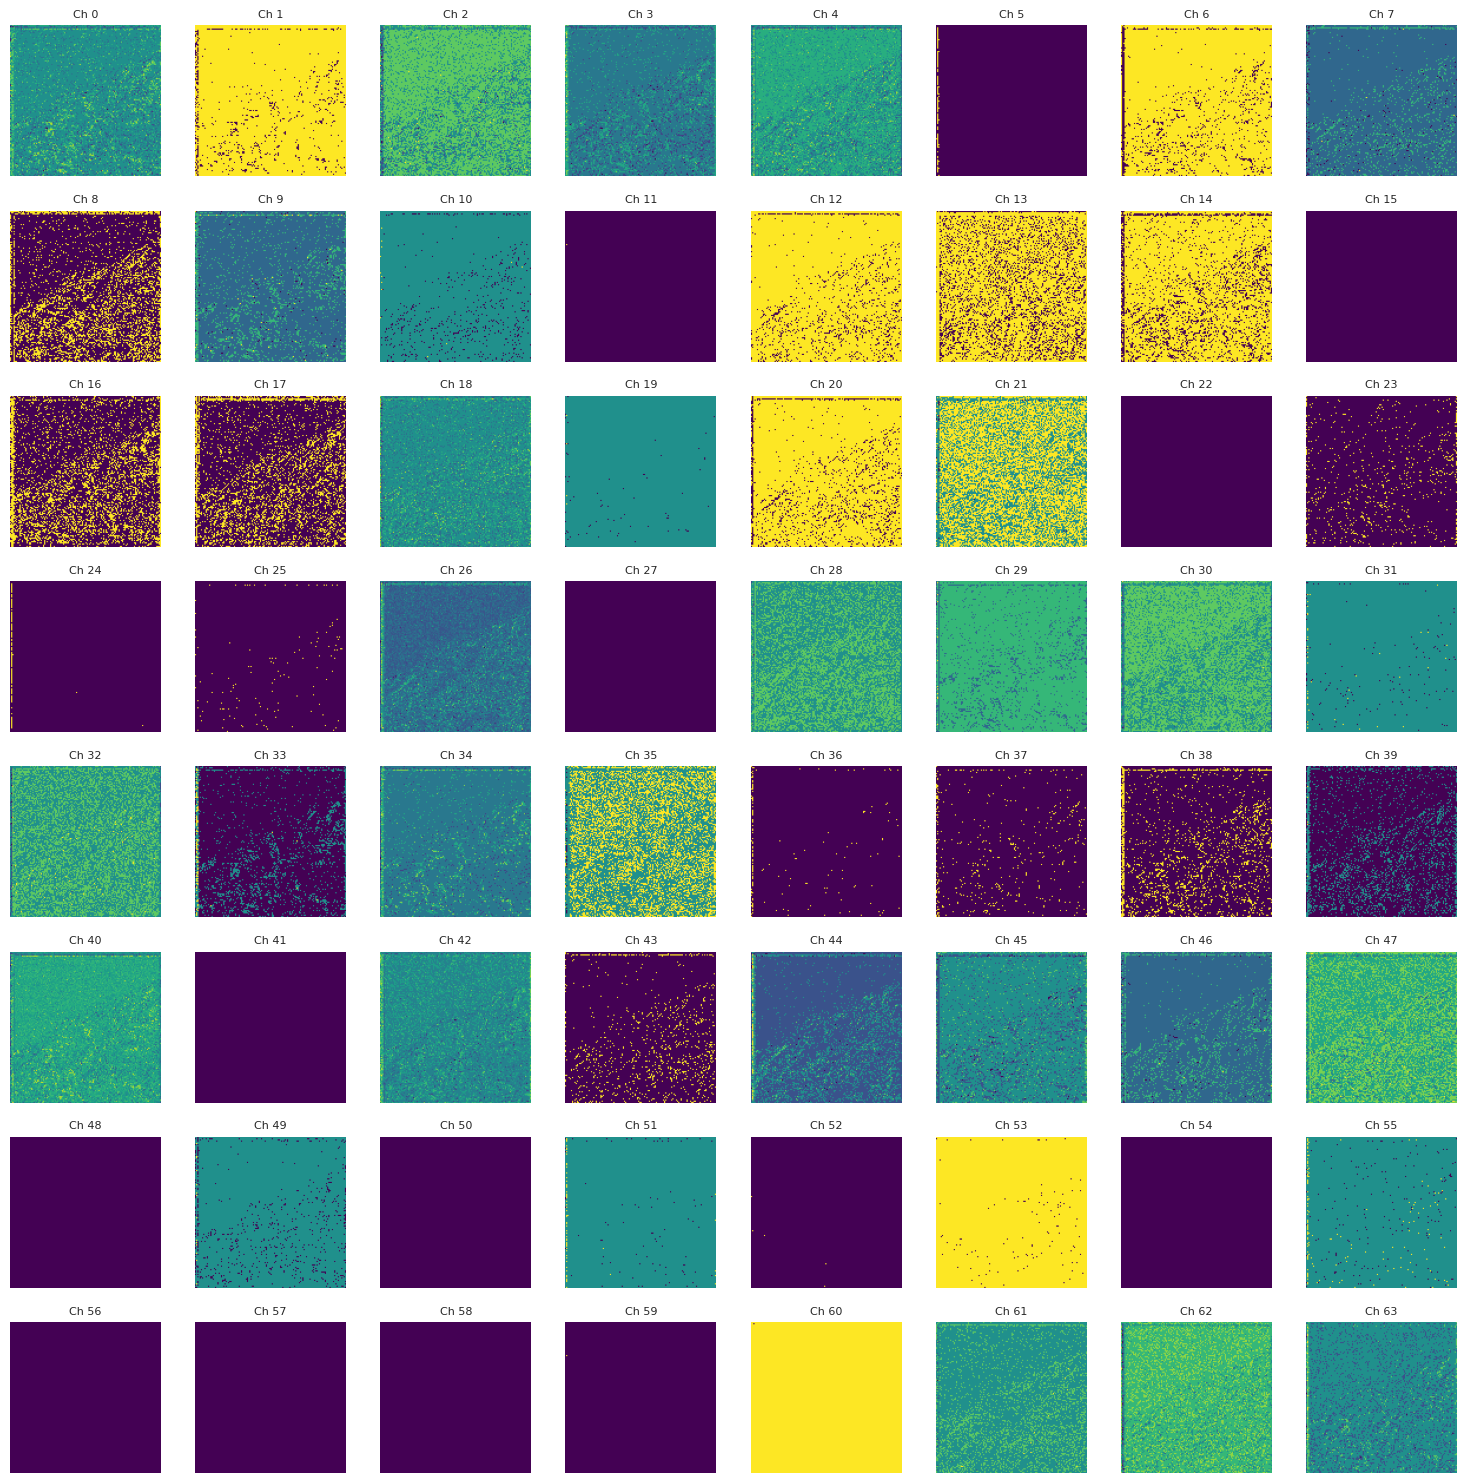

In [ ]:
x = output  # Assuming x has shape [1, 64, H, W]

fig, axes = plt.subplots(8, 8, figsize=(15, 15))  # 8x8 grid
for i in range(64):
    ax = axes[i // 8, i % 8]
    ax.imshow(x[0, i].float().detach().cpu().numpy(), cmap='viridis')
    ax.set_title(f'Ch {i}', fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()
